In [93]:
import numpy as np 
import torch
import matplotlib.pyplot as plt
#import laplace
import scipy.io 

import laplace
%matplotlib inline
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [94]:

def get_area(diff,level):
    x1,x2=chi2.interval(level,1)
    lower=len(np.where(diff<x1)[0])
    upper=len(np.where(diff>x2)[0])
    return (lower+upper)/np.prod(diff.shape)
def plot_quantiles(Y):
    quantiles=[.01*i for i in range(100)]
    emp=[get_area(Y,1-q)for q in quantiles]
    plt.figure()
    plt.plot(quantiles,emp)
    plt.plot(quantiles,quantiles,'k')
def plot_quantiles_heat(Y):
    quantiles=[.01*i for i in range(100)]
    emp=[get_area(Y,1-q)for q in quantiles]
    norm = colors.Normalize(vmin=0, vmax=1)
    plt.figure()
    plt.imshow((np.array(emp)-np.array(quantiles))[:,np.newaxis],extent=[0,.2,0,1],norm=norm)
    plt.colorbar()
def plot_quantiles_heat_full(Y):
    quantiles=[.01*i for i in range(100)]
    areas=[]
    for e in Y:
        areas.append([get_area(e,1-q)for q in quantiles])
    norm = colors.Normalize(vmin=0, vmax=1)
    plt.figure(dpi=100)
    #plt.imshow((np.array(emp)-np.array(quantiles))[:,np.newaxis],extent=[0,.2,0,1],norm=norm)
    plt.imshow(np.array(areas).T-np.array(quantiles)[:,None],extent=[0,2,0,1],norm=norm,interpolation='nearest')
    plt.vlines(np.linspace(0,2,16)[:-1],0,1,'k')
    plt.colorbar()

In [95]:
data = scipy.io.loadmat('data/burgers_shock.mat')
t_ = torch.tensor(data['t'].flatten()).float()
x_ = torch.tensor(data['x'].flatten()).float()
Exact = np.real(data['usol']).T

#X,T=torch.meshgrid(x_,t_,indexing='xy')
#X,T=torch.meshgrid(x_,t_)
X,T=np.meshgrid(x_,t_,indexing='xy')
X=torch.tensor(X)
T=torch.tensor(T)
X_exact=X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_exact = Exact.flatten()[:,None]              

In [96]:

t = torch.linspace(0,1,251).float()
x = torch.linspace(-1,1,501).float()
bc_l=torch.vstack([-1*torch.ones_like(t),t]).T
bc_r=torch.vstack([torch.ones_like(t),t]).T
ic=torch.vstack([x,torch.zeros_like(x)]).T
data_grid=torch.vstack([bc_l,bc_r,ic])
x=data_grid[:,0]
t=data_grid[:,1]
#X,T=torch.meshgrid(x,t,indexing='xy')
u_star=torch.as_tensor([-np.sin(i[0]*np.pi) if i[1]==0 else 0. for i in data_grid])[:,None]

# Experiments

In [97]:
from importlib import reload
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
import plotting
reload(plotting)

<module 'plotting' from 'e:\\UnizeugMaster\\MasterarbeitAlbrecht\\laplacePINN\\laplacePINNs\\laplacePINN\\plotting.py'>

In [98]:
'''
errs=[]
means=[]
variances=[]
covariances=[]
grids=[]
for n_points in [2**i for i in range(2,17)]:
    u_err,post_mean,post_variance,post_covariance,dots= plotting.getLaplace(iters=60000,n_col=n_points)
    errs.append(u_err)
    means.append(post_mean.numpy())
    variances.append(post_variance.numpy())
    covariances.append(post_covariance.numpy())
    grids.append(dots.numpy())
    print(n_points,' points done')
'''

"\nerrs=[]\nmeans=[]\nvariances=[]\ncovariances=[]\ngrids=[]\nfor n_points in [2**i for i in range(2,17)]:\n    u_err,post_mean,post_variance,post_covariance,dots= plotting.getLaplace(iters=60000,n_col=n_points)\n    errs.append(u_err)\n    means.append(post_mean.numpy())\n    variances.append(post_variance.numpy())\n    covariances.append(post_covariance.numpy())\n    grids.append(dots.numpy())\n    print(n_points,' points done')\n"

In [99]:
#np.savez('experiment6,power2smallmiddleGrid.npz',errs,means,variances,covariances,grids)

# Plotting


In [100]:
eee=np.load('data/experiment2,power2equalGrid2.npz',allow_pickle=True,)
errs=eee['arr_0'].squeeze()[:-1,:]
var_cpu=eee['arr_2'].squeeze()[:-1,:]
mean_cpu=eee['arr_1'].squeeze()[:-1,:]
covariances_cpu=eee['arr_3'].squeeze()[:-1,:]
grids=eee['arr_4'].squeeze()[:-1]

In [101]:
import tueplots
import seaborn as sns
from tueplots import bundles
plt.rcParams.update(bundles.iclr2024())
plt.rcParams.update({'axes.formatter.limits':'-3,6'})
plt.rcParams['figure.dpi'] = 500

In [102]:

def plot_burger(Y,plot_points=None,normcenter=None,title=None):
    if normcenter is not None:
        divnorm=colors.TwoSlopeNorm(vcenter=normcenter)
        cm='coolwarm'
    else:
        divnorm=None
        cm='Spectral_r'
    plt.figure(dpi=50)
    if title:
        plt.title(title)
    U_std = griddata(X_exact, Y.flatten(), (X, T), method='nearest')
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1.0/3.0+0.06, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])

    h = ax.imshow(((U_std)).T, interpolation='nearest', cmap=cm,norm=divnorm, extent=[t.min(), t.max(), x.min(), x.max()], origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(h, cax=cax)

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    #plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    if plot_points is not None and plot_points.size !=0:
        x_col=plot_points[:,0]
        t_col=plot_points[:,1]
        ax.plot(t_col,x_col, 'kx', markersize = .8, clip_on = False)
def burger_quantile(Y,alpha,plot_points=None,title=None):
    c1,c2=chi2.ppf([alpha/2,1-alpha/2],1)
    bounds = [c1,c2]
    divnorm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')
    plt.figure(dpi=100,figsize=(9,11))
    if title:
        plt.title(title)
    U_Y = griddata(X_exact, Y, (X, T), method='nearest')
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1.0/3.0+0.06, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])

    h = ax.imshow(U_Y.T, interpolation='nearest',norm=divnorm, cmap='seismic', extent=[t.min(), t.max(), x.min(), x.max()], origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(h, cax=cax)

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    #plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    if plot_points is not None and plot_points.size !=0:
        x_col=plot_points[:,0]
        t_col=plot_points[:,1]

        ax.plot(t_col,x_col, 'kx', markersize = .8, clip_on = False)

KeyboardInterrupt: 

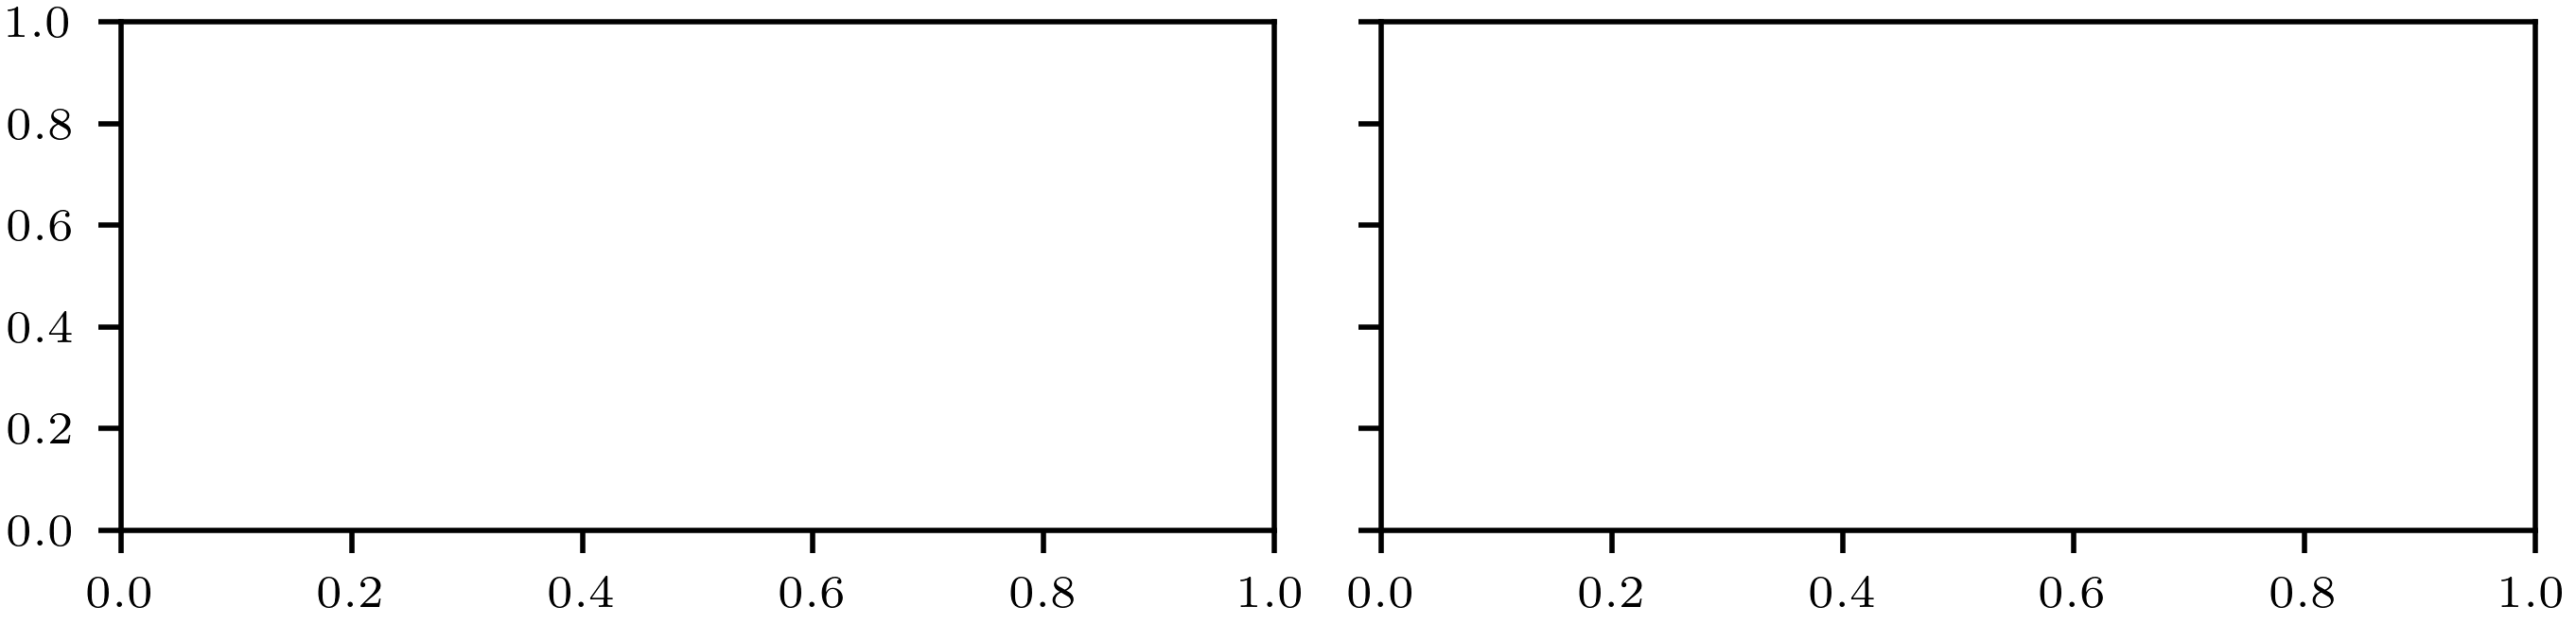

In [103]:
from tueplots import figsizes
index=[0,1]
cmap='Spectral_r'
idx=9
arr=[errs[idx,:]**2,np.sqrt(var_cpu[idx,:]**2)]

plt.rcParams.update(figsizes.neurips2021(nrows=1, ncols=2,height_to_width_ratio=.5))
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
alpha=.05
#fig.text(0.5, -0.0, 'common X', ha='center')
#fig.text(-0.0, 0.5, 'common Y', va='center', rotation='vertical')
for ax,i in zip(axes.flatten(),index):
    U_Y = griddata(X_exact, arr[i], (X, T), method='nearest')
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1.0/3.0+0.06, left=0.15, right=0.85, wspace=0)

    h = ax.imshow(((U_Y)).T, interpolation='nearest', cmap=cmap, extent=[t.min(), t.max(), x.min(), x.max()], origin='lower', aspect='auto')
    #h = ax.imshow(U_Y.T, interpolation='nearest',norm=divnorm, cmap='coolwarm', extent=[t.min(), t.max(), x.min(), x.max()], origin='lower', aspect='auto')
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad=0.05)
    #fig.colorbar(h, cax=cax)

    #ax.set_xlabel('$t$')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(h, cax=cax, orientation='vertical')
    #ax.set_ylabel('$x$')
    plot_points=grids[idx]
    x_col=plot_points[:,0]
    t_col=plot_points[:,1]
    ax.plot(t_col,x_col, 'kx', markersize = .3, clip_on = False)
axes[0].set_title('Squared Error')
axes[1].set_title('Predicted Variance')
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust()
fig.supxlabel('$t$')
fig.supylabel('$x$')
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#cax = divider.append_axes("right", size="5%", pad=0.05)
#fig.colorbar(h, cax=cbar_ax)
#fig.colorbar(h, ax=axes.ravel().tolist())
plt.show()

In [ ]:
def plot_burger_2x1(arr,index,grids):
    plt.rcParams.update(figsizes.neurips2021(nrows=1, ncols=2,height_to_width_ratio=.5))
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
    alpha=.05
    #fig.text(0.5, -0.0, 'common X', ha='center')
    #fig.text(-0.0, 0.5, 'common Y', va='center', rotation='vertical')
    for ax,i in zip(axes.flatten(),index):
        arr=np.array(arr)
        vmin=(arr.min())
        vmax=(arr.max())
        plt.figure()
        U_Y = griddata(X_exact, arr[i,:], (X, T), method='nearest')
        gs0 = gridspec.GridSpec(1, 2)
        gs0.update(top=1-0.06, bottom=1-1.0/3.0+0.06, left=0.15, right=0.85, wspace=0)
        h = ax.imshow(((U_Y)).T, interpolation='nearest', cmap=cmap, extent=[t.min(), t.max(), x.min(), x.max()], origin='lower', aspect='auto')
        #h = ax.imshow(U_Y.T, interpolation='nearest',norm=divnorm, cmap='coolwarm', extent=[t.min(), t.max(), x.min(), x.max()], origin='lower', aspect='auto')
        #divider = make_axes_locatable(ax)
        #cax = divider.append_axes("right", size="5%", pad=0.05)
        #fig.colorbar(h, cax=cax)

        #ax.set_xlabel('$t$')
        #ax.set_ylabel('$x$')
        plot_points=grids[i]
        x_col=plot_points[:,0]
        t_col=plot_points[:,1]
        ax.plot(t_col,x_col, 'kx', markersize = .5, clip_on = False)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(h, cax=cax, orientation='vertical')
    #fig.subplots_adjust(right=0.8)
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    #cax = divider.append_axes("right", size="5%", pad=0.05)
    #fig.colorbar(h, cax=cbar_ax)
    #fig.colorbar(h, ax=axes.ravel().tolist())
    plt.show()

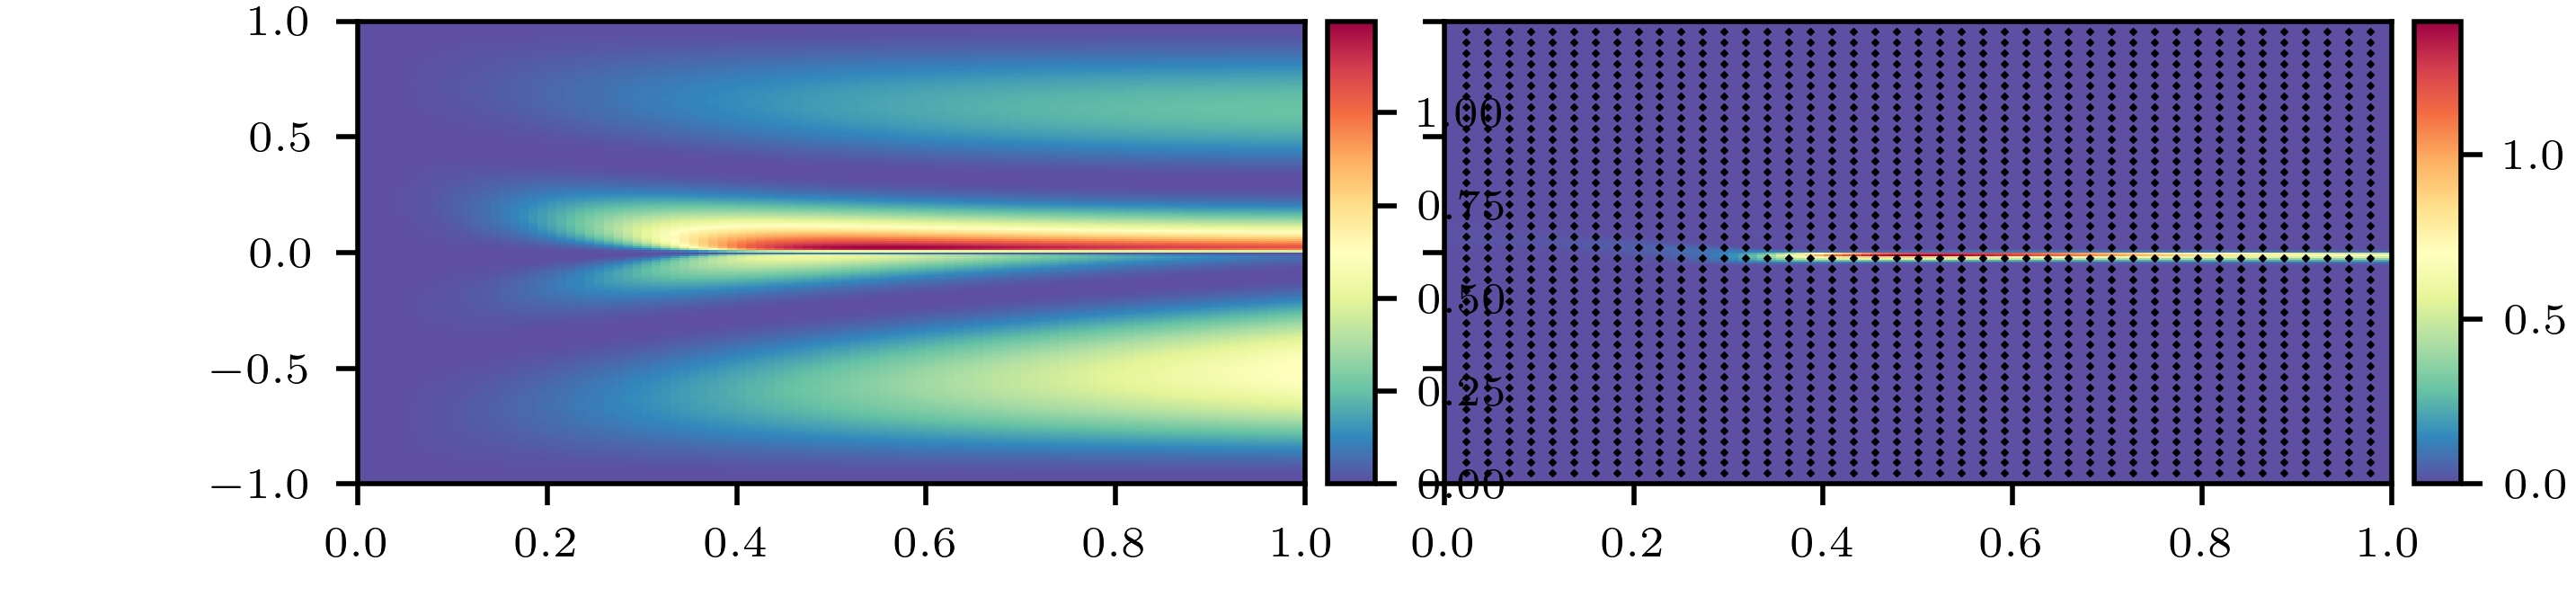

<Figure size 2750x687.5 with 0 Axes>

<Figure size 2750x687.5 with 0 Axes>

In [116]:
cmap=sns.color_palette("Spectral_r", as_cmap=True)#diese gut
#cmap=sns.color_palette("Spectral_r", as_cmap=True)
#cmap=sns.color_palette("viridis", as_cmap=True)
#cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
plot_burger_2x1(errs**2,[1,9],grids)

In [ ]:

from tueplots import figsizes
def plot_burger_2x2(arr,index,grids):
    plt.rcParams.update(figsizes.neurips2021(nrows=2, ncols=2,height_to_width_ratio=.5))
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
    alpha=.05
    #fig.text(0.5, -0.0, 'common X', ha='center')
    #fig.text(-0.0, 0.5, 'common Y', va='center', rotation='vertical')
    for ax,i in zip(axes.flatten(),index):
        plt.figure()
        U_Y = griddata(X_exact, arr[i,:], (X, T), method='nearest')
        gs0 = gridspec.GridSpec(1, 2)
        gs0.update(top=1-0.06, bottom=1-1.0/3.0+0.06, left=0.15, right=0.85, wspace=0)

        h = ax.imshow(((U_Y)).T, interpolation='nearest', cmap=cmap, extent=[t.min(), t.max(), x.min(), x.max()], origin='lower', aspect='auto')
        #h = ax.imshow(U_Y.T, interpolation='nearest',norm=divnorm, cmap='coolwarm', extent=[t.min(), t.max(), x.min(), x.max()], origin='lower', aspect='auto')
        #divider = make_axes_locatable(ax)
        #cax = divider.append_axes("right", size="5%", pad=0.05)
        #fig.colorbar(h, cax=cax)
        #ax.set_yticks([-1,1])

        #ax.set_xlabel('$t$')
        #ax.set_ylabel('$x$')
        plot_points=grids[i]
        x_col=plot_points[:,0]
        t_col=plot_points[:,1]
        ax.plot(t_col,x_col, 'kx', markersize = .3, clip_on = False)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbar=fig.colorbar(h, cax=cax, orientation='vertical')
        #cbar.ax.set_yticks([-1,0,1])
    fig.subplots_adjust()
    
    #axes[1,0].set_xlabel('$t$')
    #axes[1,1].set_xlabel('$t$')
    fig.supxlabel('$t$')
    fig.supylabel('$x$')
    fig.suptitle('$(u_{\\theta}(t,x)-u^*(t,x))^2$')
    #fig.suptitle('$u_{\\theta}(t,x)$')
    #fig.suptitle('Posterior variance $\sigma_i^2$')

    #plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    #fig.subplots_adjust(right=0.8)
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    #cax = divider.append_axes("right", size="5%", pad=0.05)
    #fig.colorbar(h, cax=cbar_ax)
    #fig.colorbar(h, ax=axes.ravel().tolist())
    plt.show()

C:\Users\thoma\AppData\Local\Temp\ipykernel_8736\3477980716.py:31: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust()


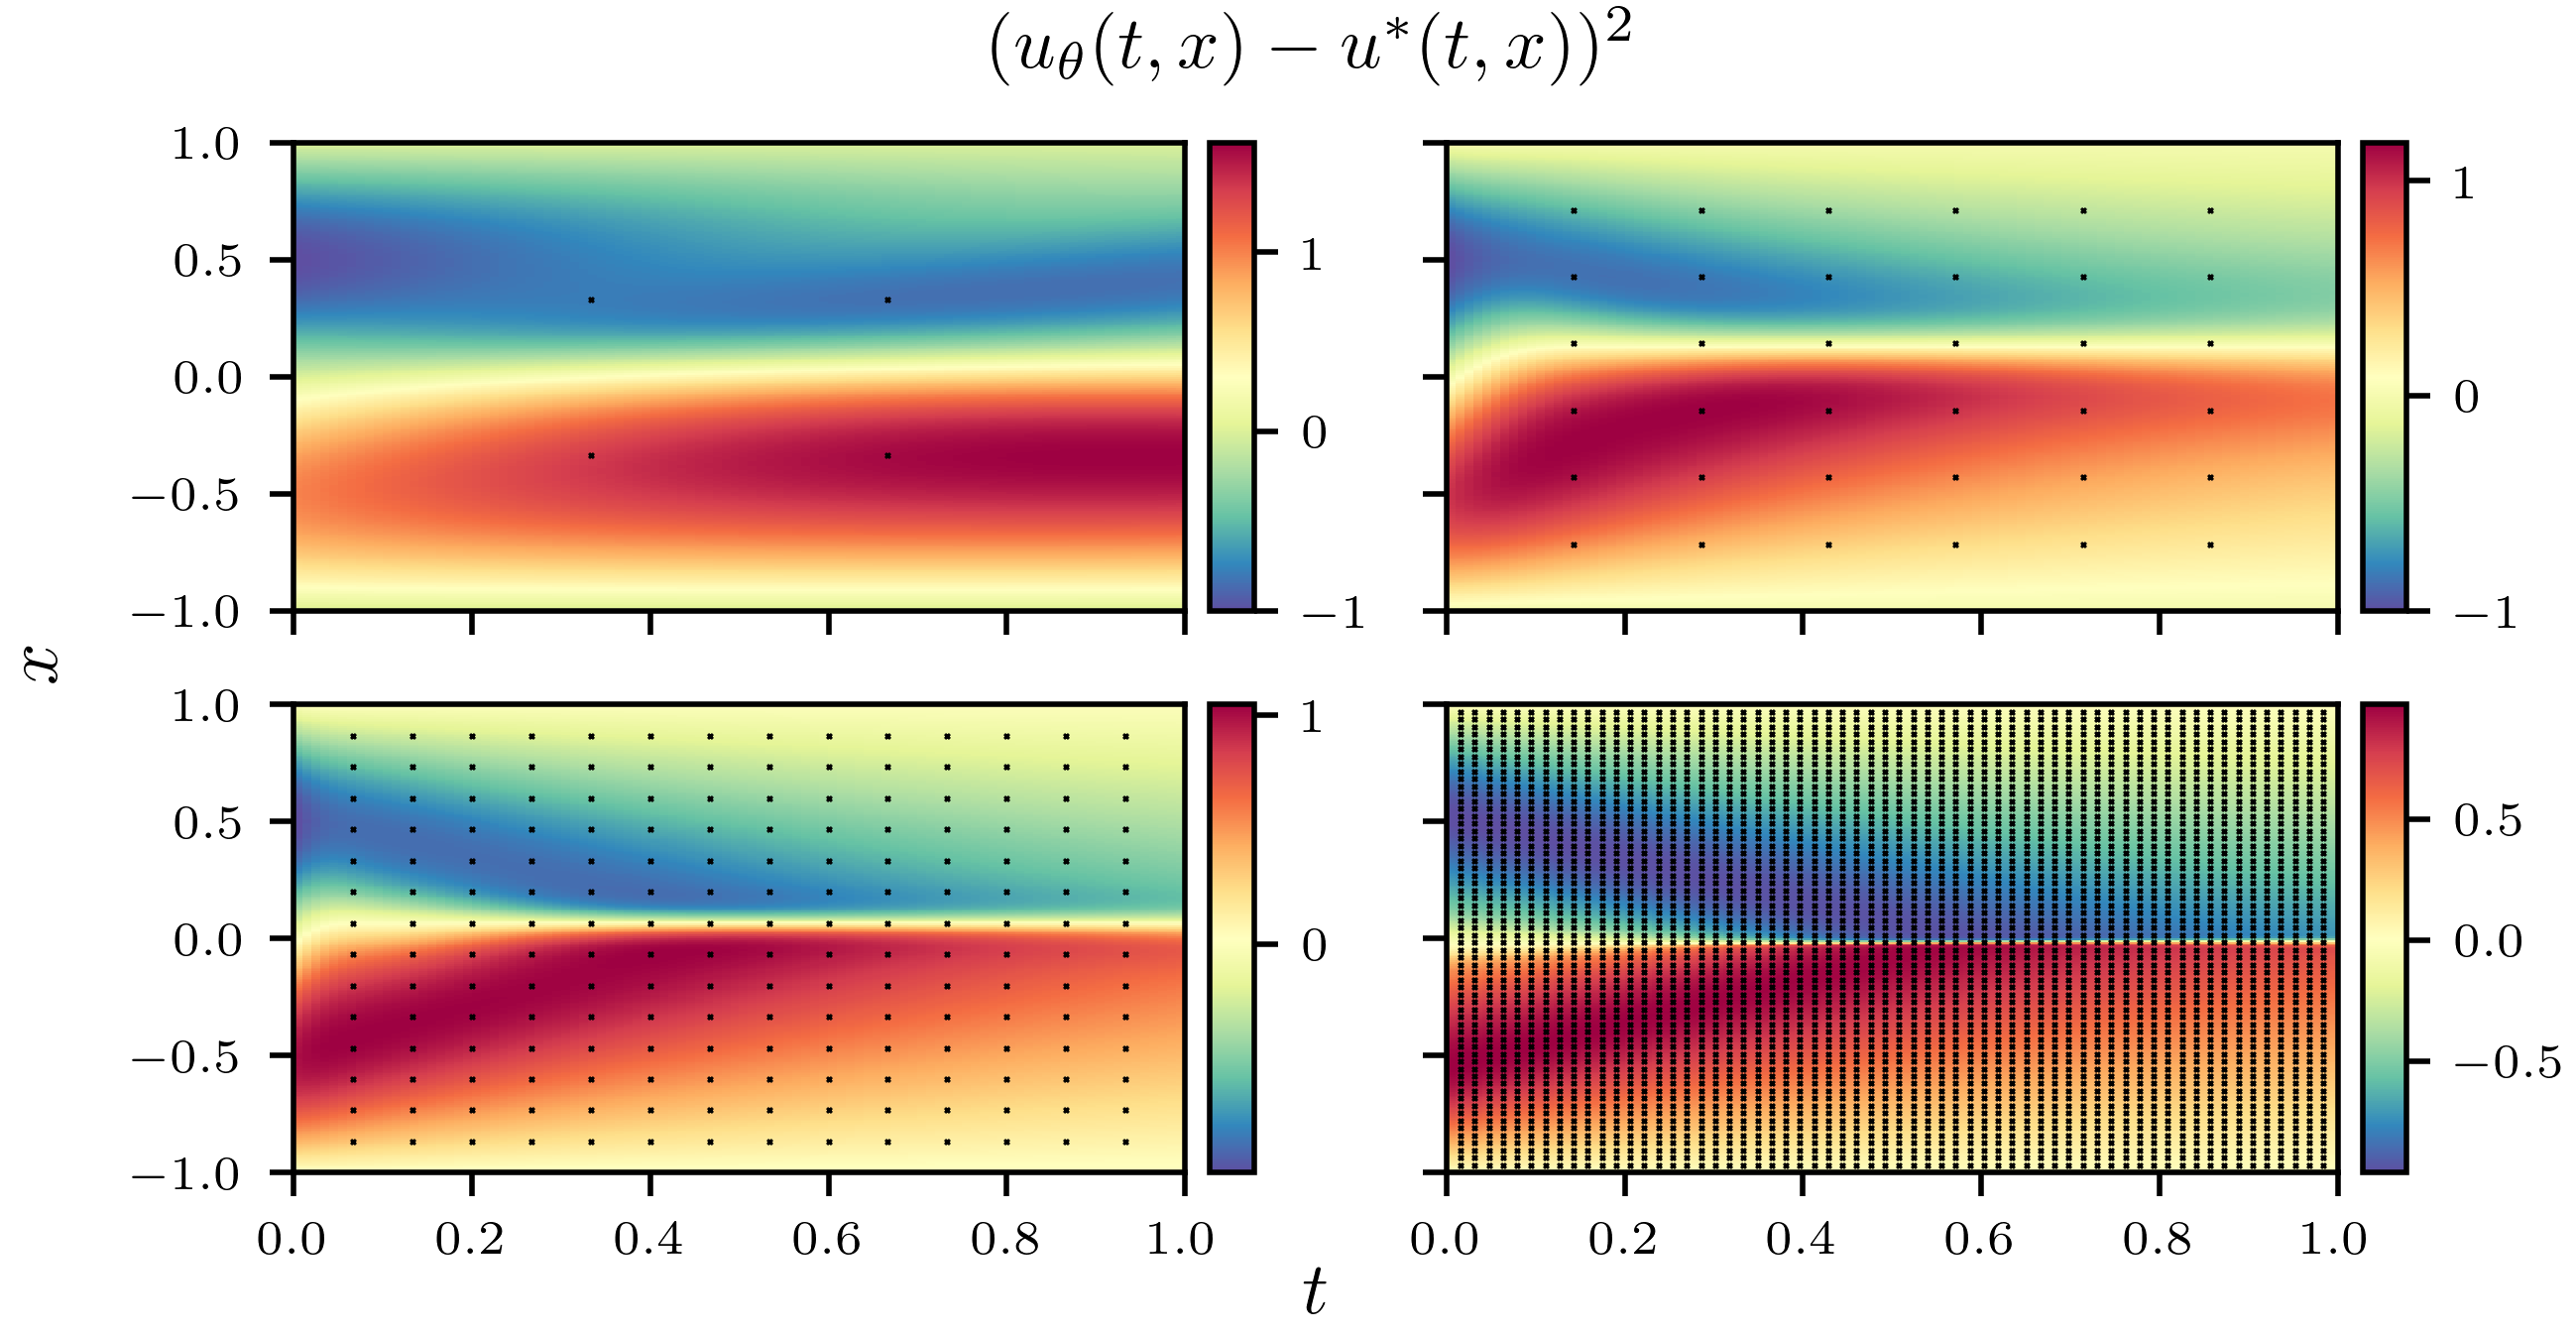

<Figure size 2750x1375 with 0 Axes>

<Figure size 2750x1375 with 0 Axes>

<Figure size 2750x1375 with 0 Axes>

<Figure size 2750x1375 with 0 Axes>

In [ ]:
cmap=sns.color_palette("Spectral_r", as_cmap=True)#diese gut
#plot_burger_2x2(mean_cpu,[2,6,8,10],grids)
plot_burger_2x2(mean_cpu,[2,4,6,10],grids)
#plot_burger_2x2(mean_cpu,[2,4,6,9],grids)

In [ ]:
cmap=sns.color_palette("Spectral_r", as_cmap=True)#diese gut
plot_burger_2x2(errs**2,[2,6,8,10],grids)
#plot_burger_2x2(errs**2,[2,5,9,10],grids)

C:\Users\thoma\AppData\Local\Temp\ipykernel_8736\3477980716.py:31: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust()


KeyboardInterrupt: 

C:\Users\thoma\AppData\Local\Temp\ipykernel_8736\2784842685.py:24: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust()


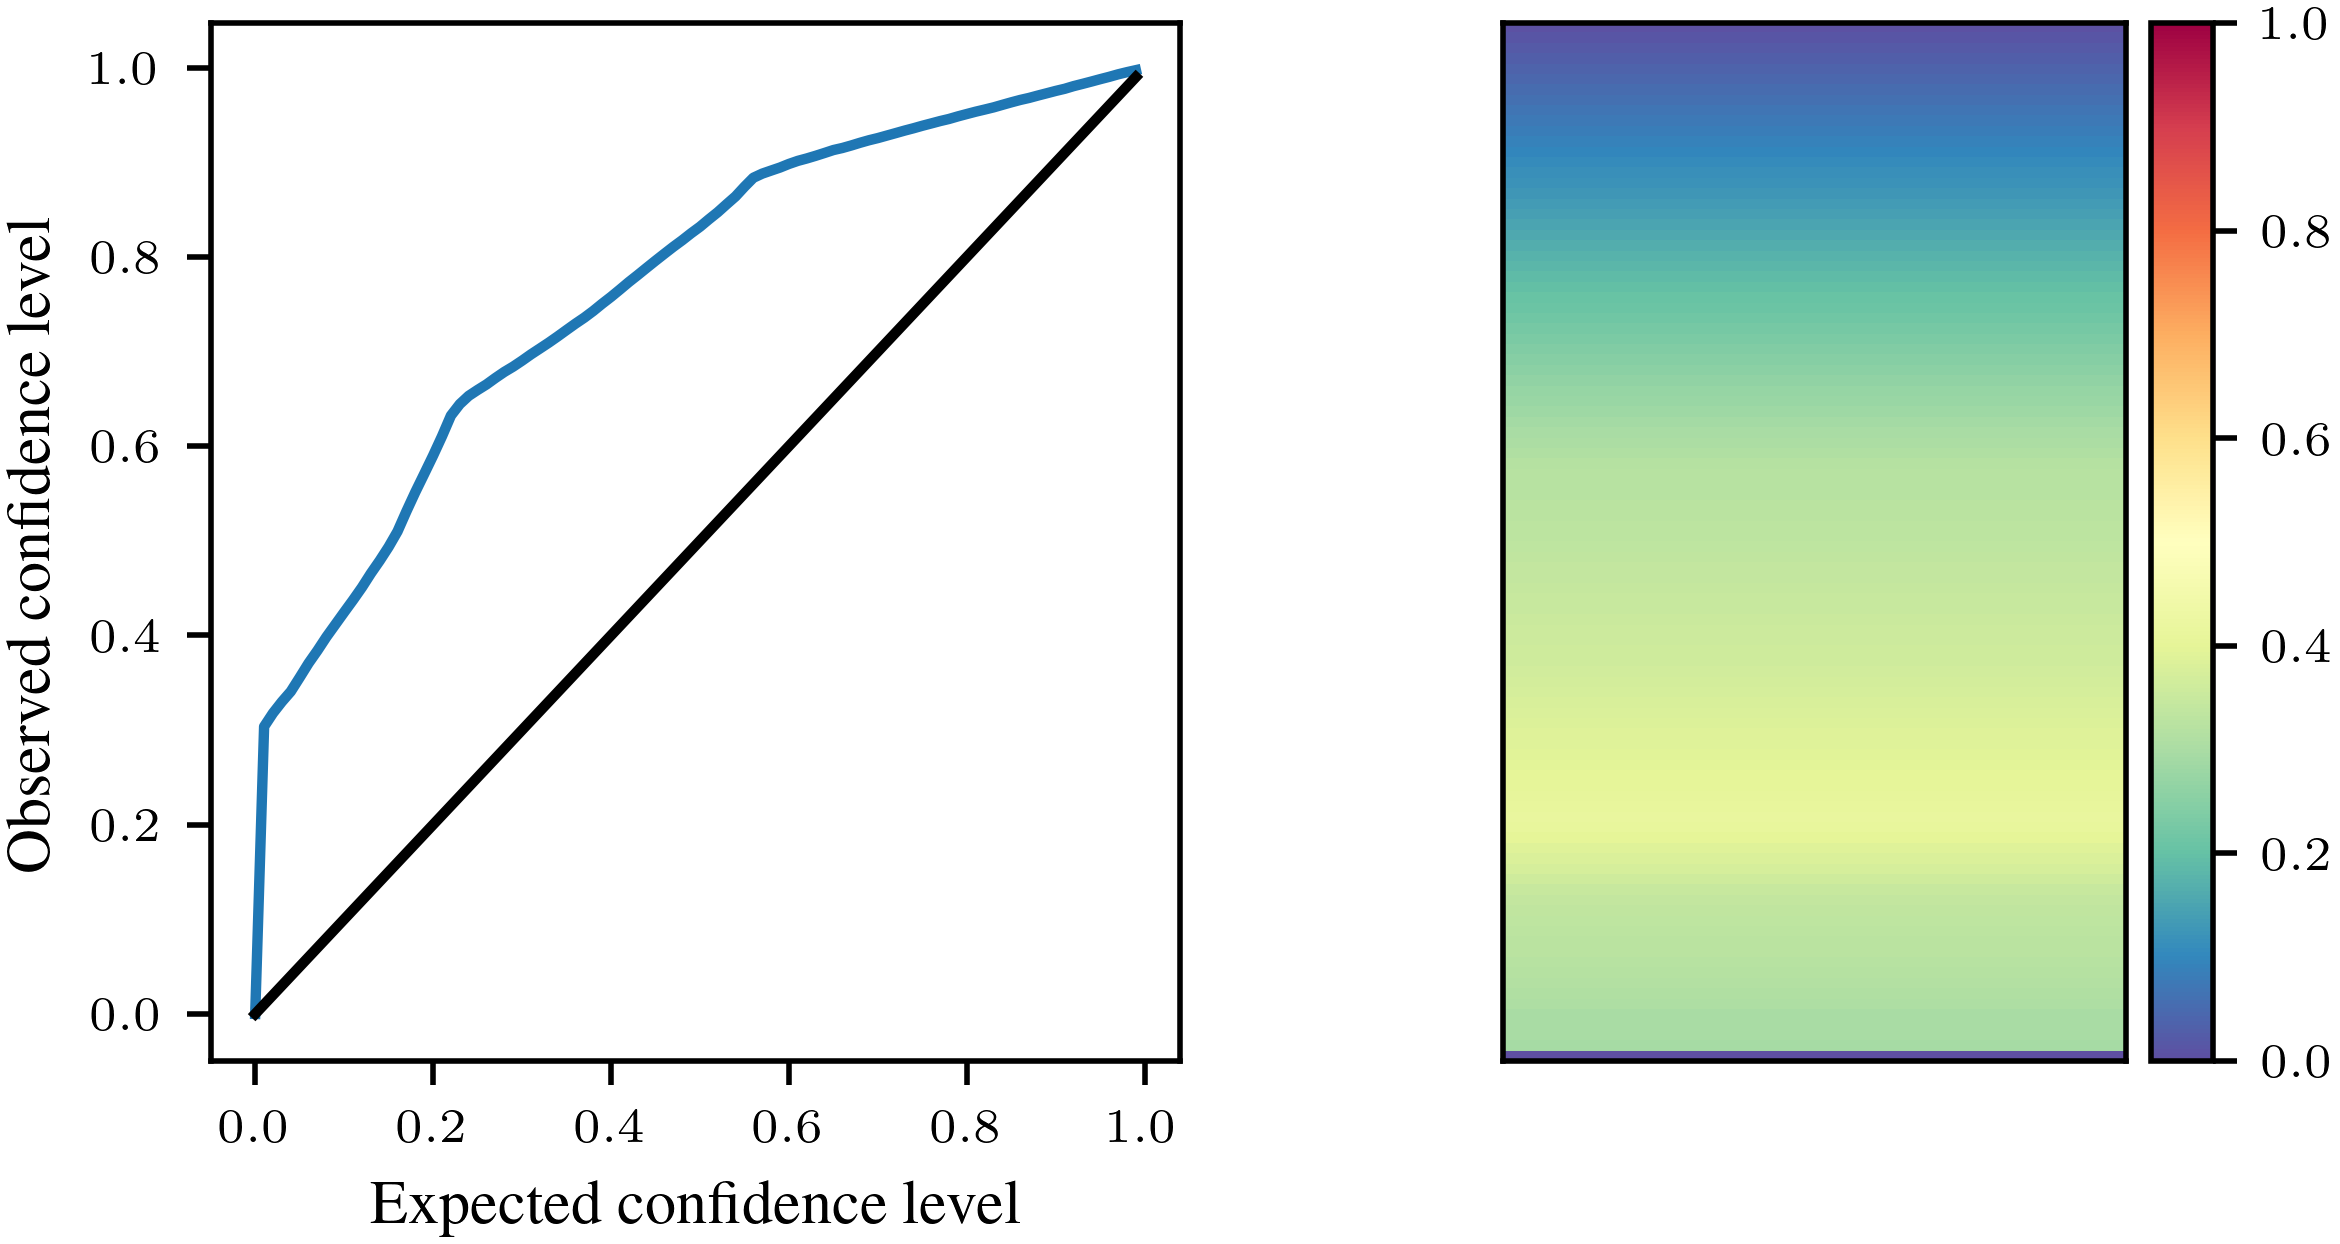

In [ ]:
from scipy.stats import chi2
cmap='Spectral_r'
plt.rcParams.update(figsizes.neurips2021(nrows=1, ncols=2,height_to_width_ratio=1))
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
idx=13
arr=[errs[idx,:]**2,np.sqrt(var_cpu[idx,:]**2)]
Y=arr[0]/arr[1]
quantiles=[.01*i for i in range(100)]
emp=[get_area(Y,1-q)for q in quantiles]
axes[0].plot(quantiles,emp)
axes[0].plot(quantiles,quantiles,'k')
axes[0].set_xlabel('Expected confidence level')
axes[0].set_ylabel('Observed confidence level')
emp=[get_area(Y,1-q)for q in quantiles]
norm = colors.Normalize(vmin=0, vmax=1)
h=axes[1].imshow((np.array(emp)-np.array(quantiles))[::-1][:,np.newaxis],extent=[0.2,.8,0,1],norm=norm,cmap=cmap)
#h=axes[1].imshow((np.array(emp)-np.array(quantiles))[:,np.newaxis],extent=[0.2,.4,0,1],norm=norm,cmap=cmap)
axes[1].set_xticks([])
axes[1].set_yticks([])
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="10%", pad=0.05)
plt.colorbar(h, cax=cax)

fig.subplots_adjust()

[Text(0.07142857142857142, 0, '$2^2$'),
 Text(0.5, 0, '$2^5$'),
 Text(0.9285714285714285, 0, '$2^8$'),
 Text(1.357142857142857, 0, '$2^{11}$'),
 Text(1.7857142857142856, 0, '$2^{14}$')]

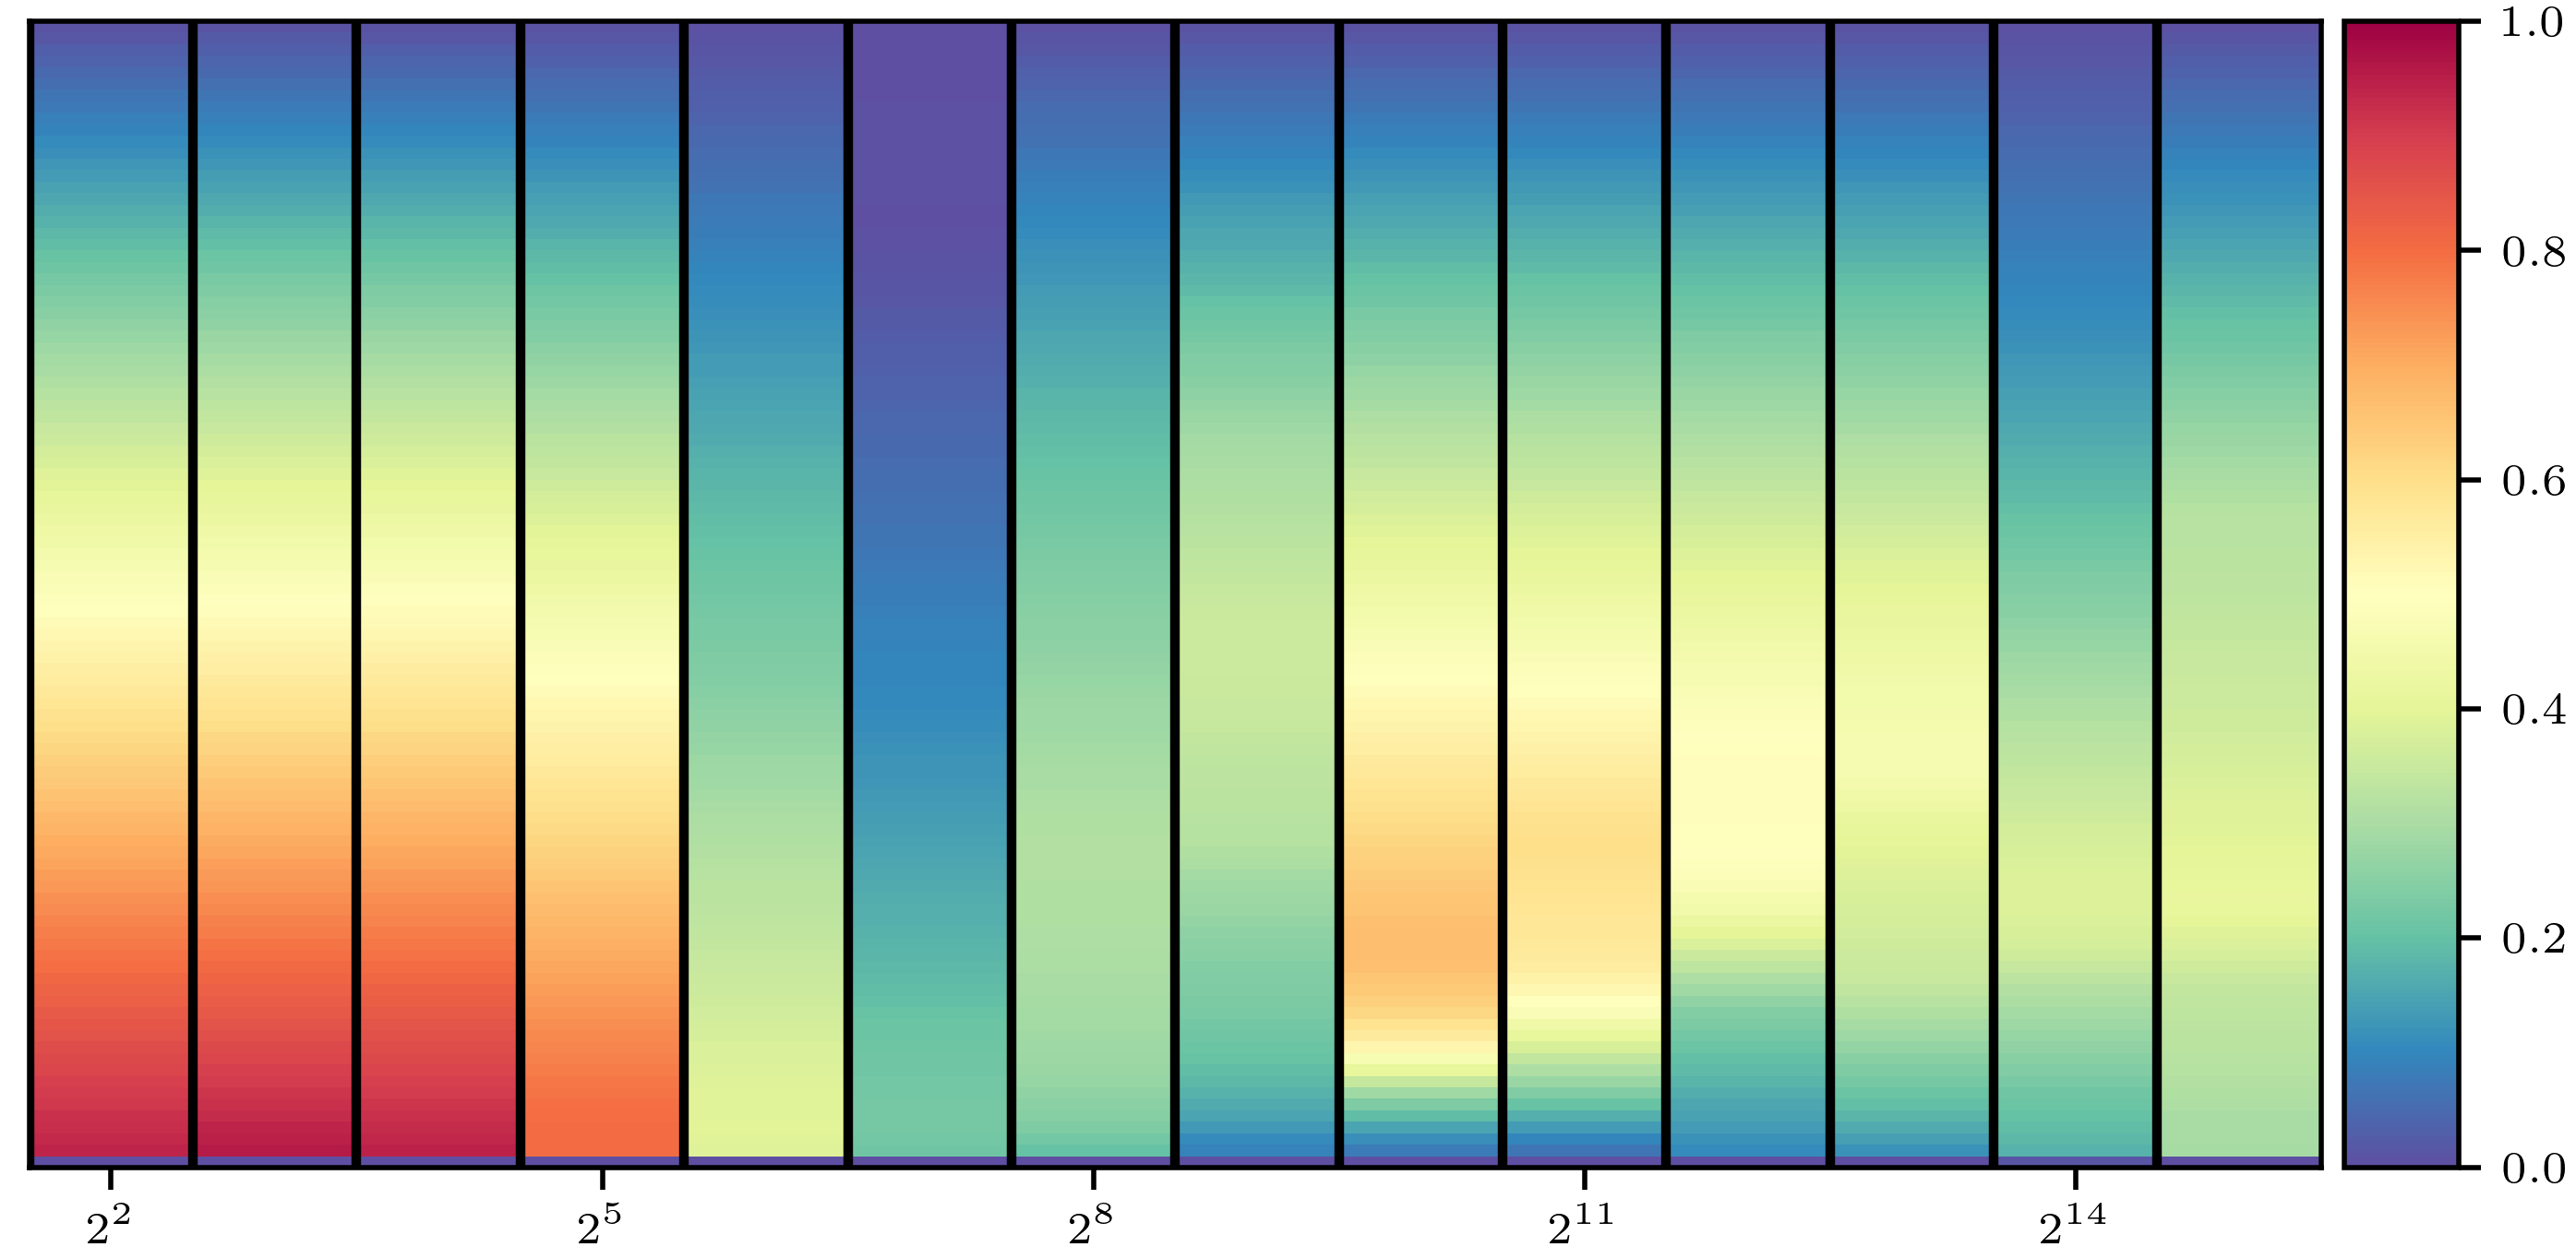

In [ ]:
cmap=sns.color_palette("Spectral_r", as_cmap=True)#diese gut
Y=errs**2/var_cpu
quantiles=[.01*i for i in range(100)]
areas=[]
for e in Y:
    areas.append([get_area(e,1-q)for q in quantiles])
norm = colors.Normalize(vmin=0, vmax=1)
ax=plt.gca()
#plt.imshow((np.array(emp)-np.array(quantiles))[:,np.newaxis],extent=[0,.2,0,1],norm=norm)
h=plt.imshow((np.array(areas).T-np.array(quantiles)[:,None])[::-1],extent=[0,2,0,1],norm=norm,interpolation='nearest',cmap=cmap)
plt.vlines(np.linspace(0,2,Y.shape[0]+1)[:-1],0,1,'k')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(h, cax=cax)
#plt.colorbar(h,fraction=0.046, pad=0.04)

ticks= np.linspace(1/14,2-1/14,14)[[(i+1)%3==True for i in range(14)]]
dic=['$2^2$','$2^5$','$2^8$','$2^{11}$','$2^{14}$']
ax.set_xticks(ticks)
ax.set_yticks([])

labels = [dic[i] for i,t in enumerate(ticks)]
ax.set_xticklabels(labels)

In [ ]:
from tueplots import figsizes
def plot_quantile_2x2(arr,index,grids,alpha):
    plt.rcParams.update(figsizes.neurips2021(nrows=2, ncols=2,height_to_width_ratio=.5))
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
    #fig.text(0.5, -0.0, 'common X', ha='center')
    #fig.text(-0.0, 0.5, 'common Y', va='center', rotation='vertical')
    for ax,i in zip(axes.flatten(),index):
        c1,c2=chi2.ppf([alpha/2,1-alpha/2],1)
        bounds = [c1,c2]
        divnorm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')
        plt.figure()
        U_Y = griddata(X_exact, arr[i,:], (X, T), method='nearest')
        gs0 = gridspec.GridSpec(1, 2)
        gs0.update(top=1-0.06, bottom=1-1.0/3.0+0.06, left=0.15, right=0.85, wspace=0)

        h = ax.imshow(U_Y.T, interpolation='nearest',norm=divnorm, cmap=cmap, extent=[t.min(), t.max(), x.min(), x.max()], origin='lower', aspect='auto')
        #divider = make_axes_locatable(ax)
        #cax = divider.append_axes("right", size="5%", pad=0.05)
        #fig.colorbar(h, cax=cax)

        #ax.set_xlabel('$t$')
        #ax.set_ylabel('$x$')
        plot_points=grids[i]
        x_col=plot_points[:,0]
        t_col=plot_points[:,1]
        ax.plot(t_col,x_col, 'kx', markersize = .5, clip_on = False)
    #fig.subplots_adjust(right=0.8)
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    #cax = divider.append_axes("right", size="5%", pad=0.05)
    #fig.colorbar(h, cax=cbar_ax)
    fig.suptitle('${}\%$ confidence interval'.format(int(100-100*alpha)))
    fig.supxlabel('$t$')
    fig.supylabel('$x$')
    fig.colorbar(h, ax=axes.ravel().tolist())
    plt.show()

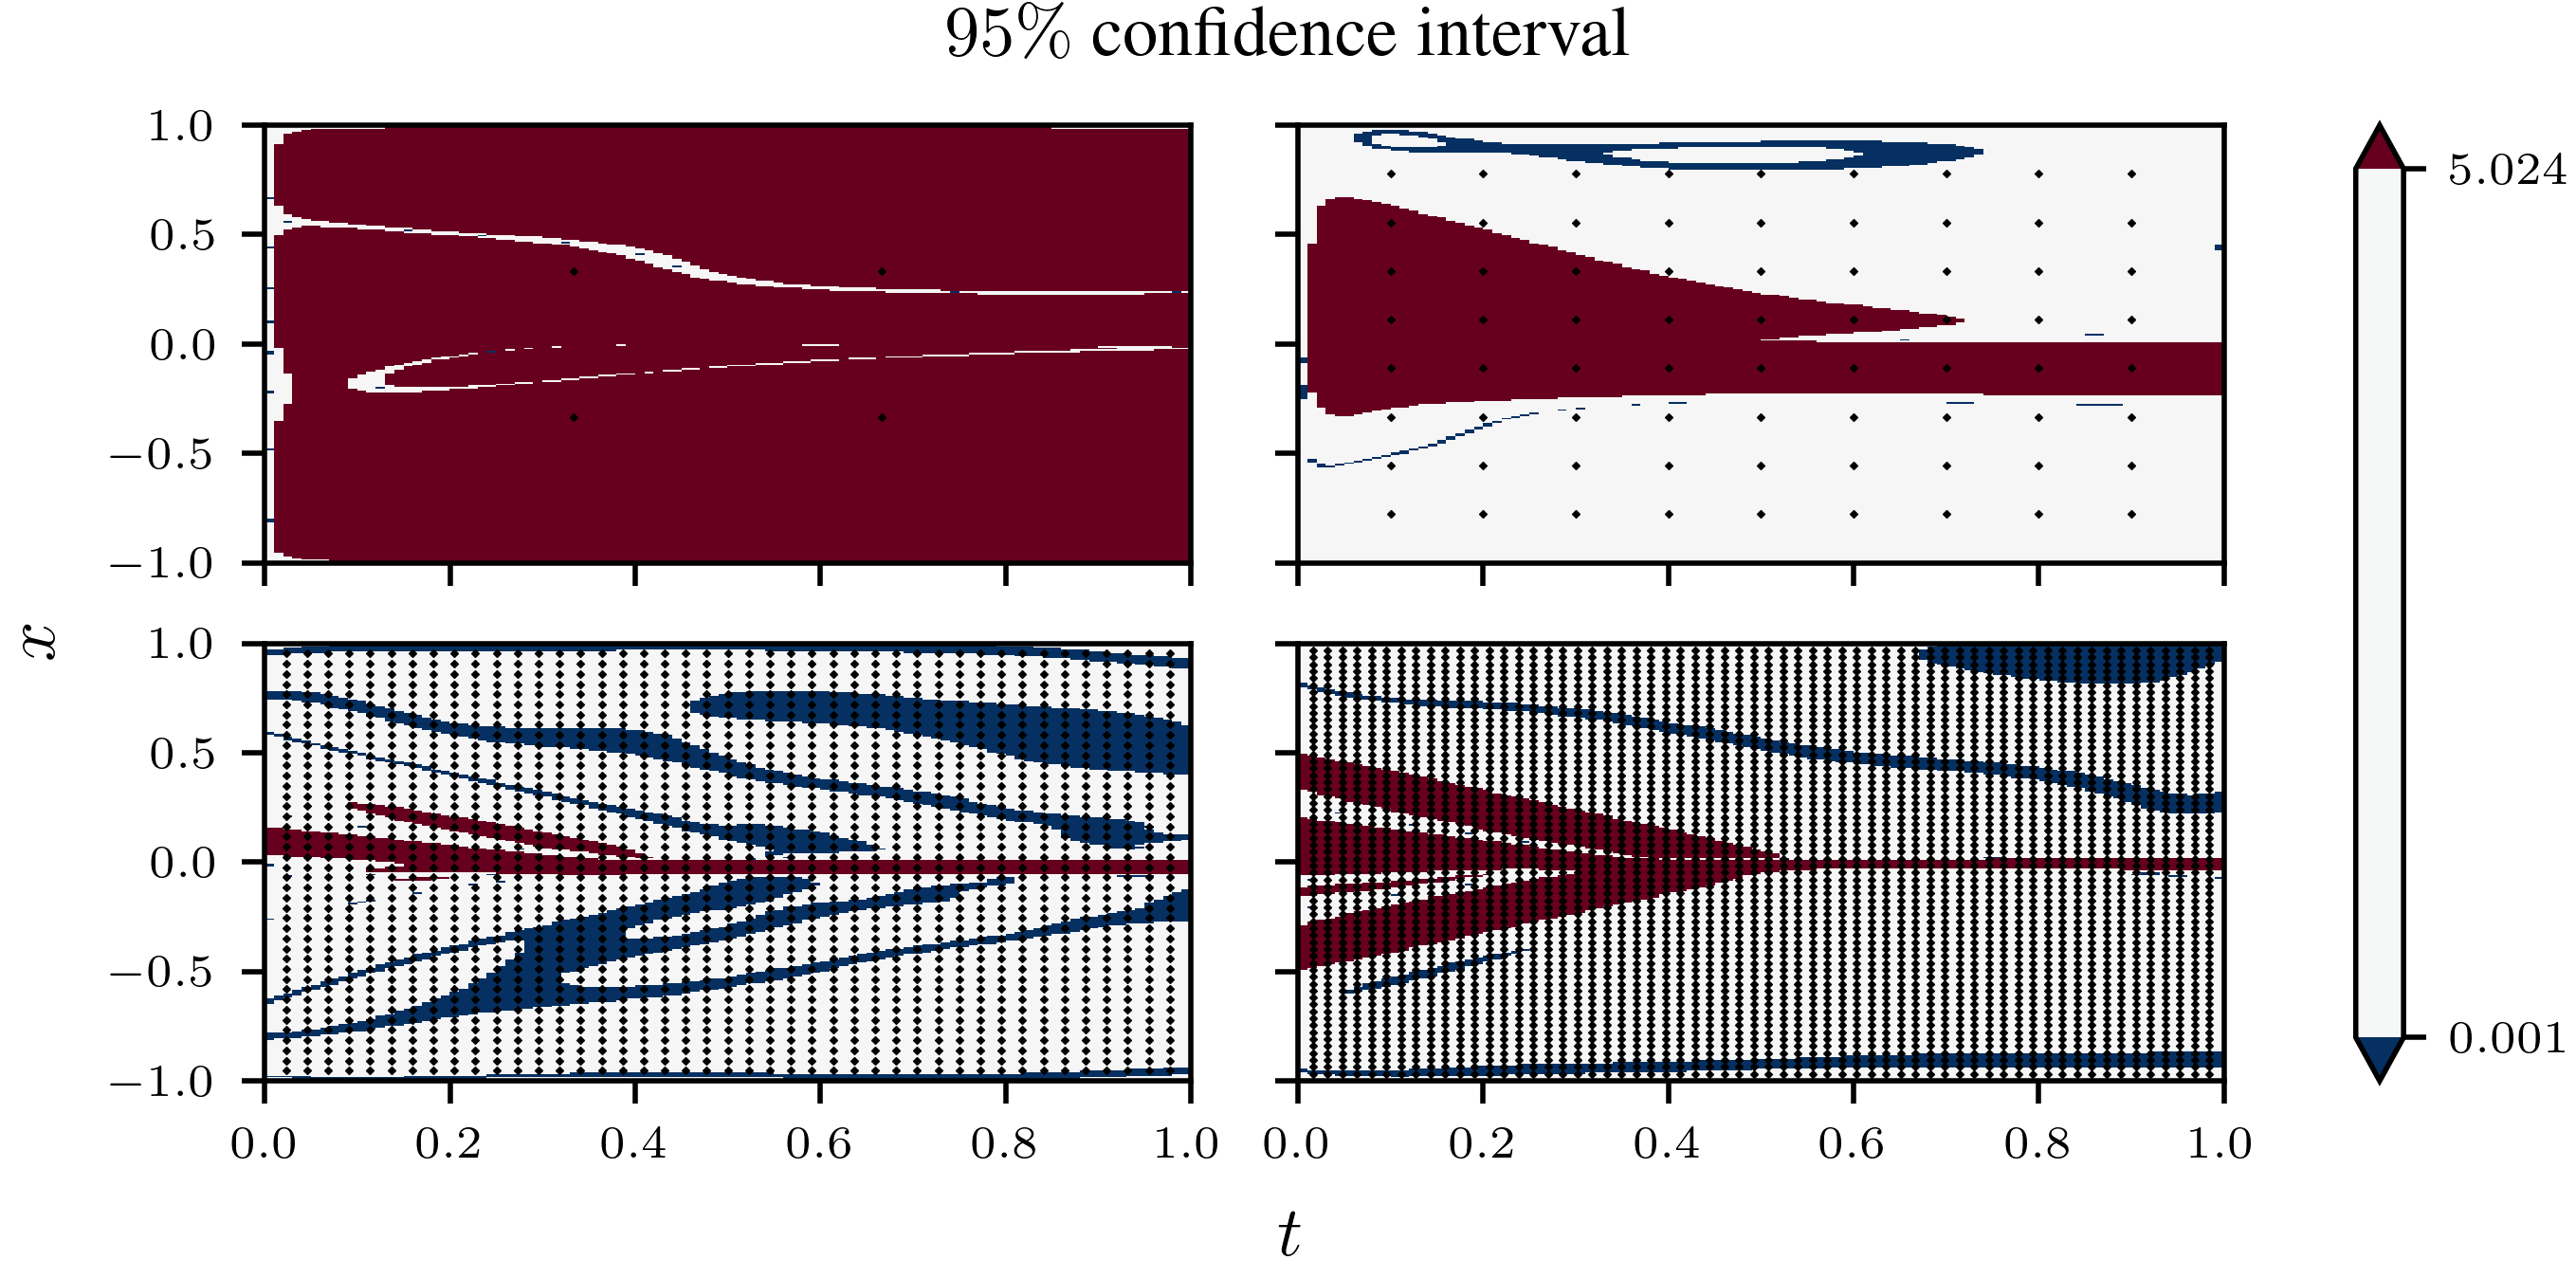

<Figure size 2750x1375 with 0 Axes>

<Figure size 2750x1375 with 0 Axes>

<Figure size 2750x1375 with 0 Axes>

<Figure size 2750x1375 with 0 Axes>

In [ ]:
cmap=sns.color_palette("RdBu_r", as_cmap=True)
#plot_quantile_2x2((errs**2)/var_cpu,[2,6,8,10],grids,.05)
plot_quantile_2x2((errs**2)/var_cpu,[2,5,9,10],grids,.05)

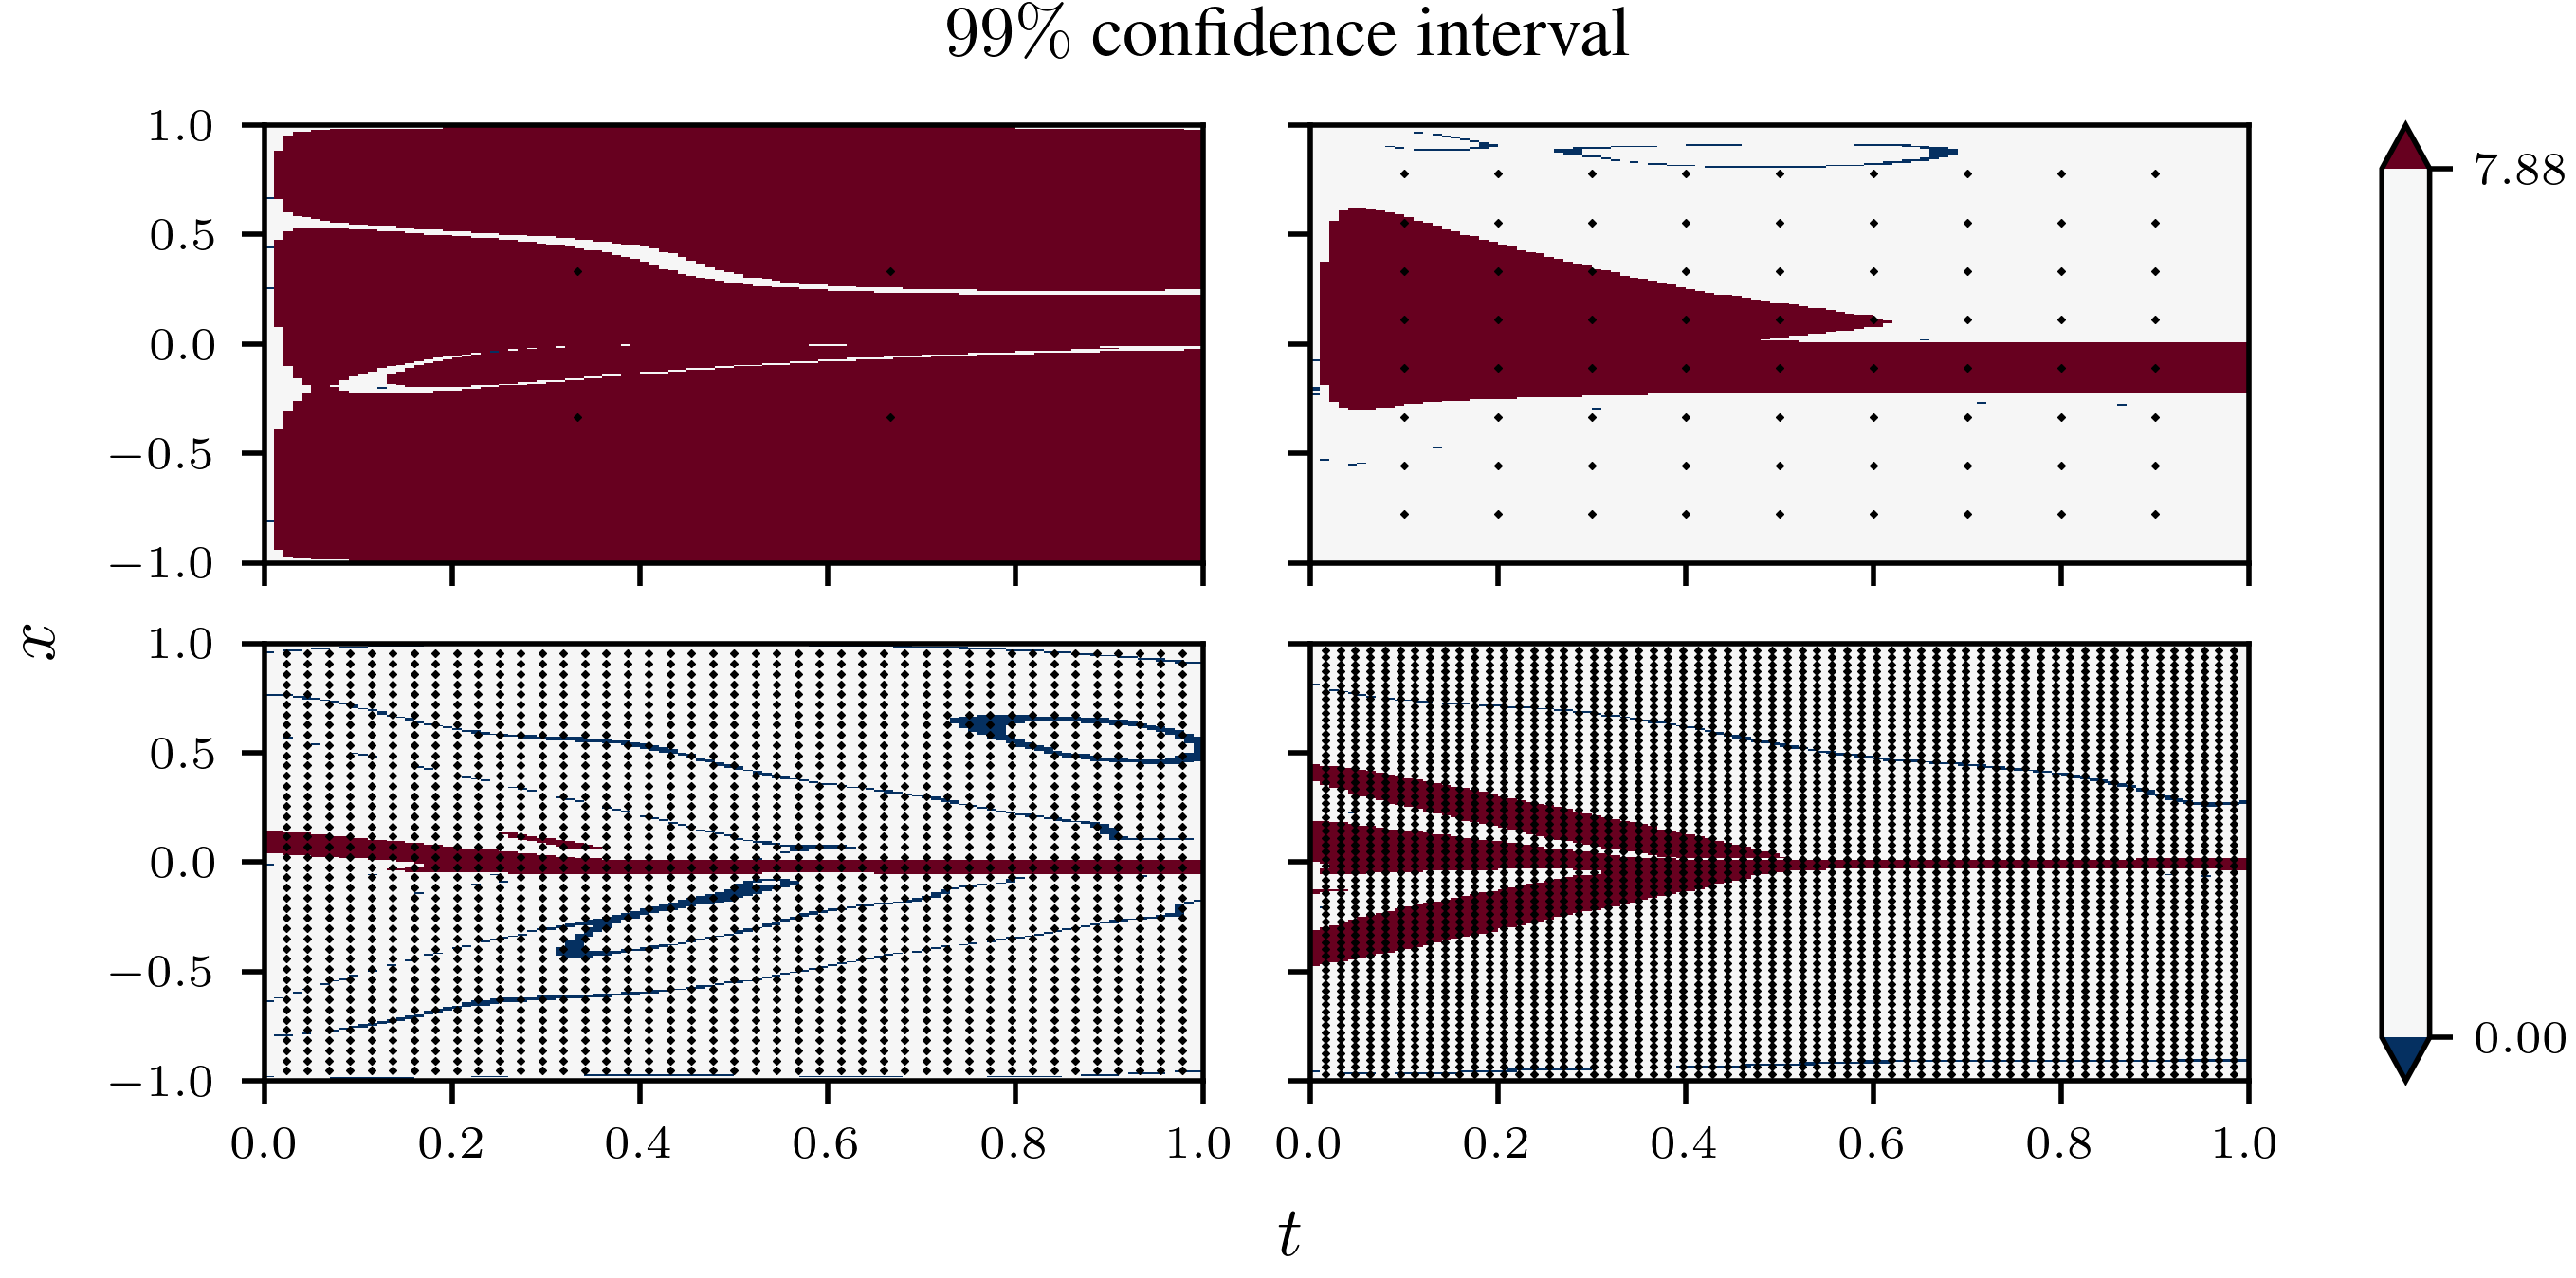

<Figure size 2750x1375 with 0 Axes>

<Figure size 2750x1375 with 0 Axes>

<Figure size 2750x1375 with 0 Axes>

<Figure size 2750x1375 with 0 Axes>

In [ ]:
cmap=sns.color_palette("RdBu_r", as_cmap=True)
#plot_quantile_2x2((errs**2)/var_cpu,[2,6,8,10],grids,.01)
plot_quantile_2x2((errs**2)/var_cpu,[2,5,9,10],grids,.01)

In [ ]:
def plot_all(errs,means,variances,covariances,grids):
    plt.plot([2**i for i in range(2,errs.shape[0]+2)],np.sqrt(np.mean(errs**2,1)))
    #plt.plot([2**i for i in range(2,errs.shape[0]+2)],np.mean((means-u_exact[None,:].squeeze())**2/u_exact.squeeze()**2,1))
    #plt.plot([2**i for i in range(2,errs.shape[0]+2)],np.linalg.norm((means-u_exact[None,:].squeeze()),axis=1)/np.linalg.norm(u_exact))
    #plt.title('$(u(x)-ui*)^2$')
    #plt.title('$(u(x)-u^*(x))^2$', fontsize = 10)
    #plt.plot([2**i for i in range(2,17)],np.linalg.norm(errs**2,axis=1)/np.prod(errs.shape))
    plt.xscale('log',base=2)#
    plt.xlabel('Grid Points')
    plt.yscale('log')
    plt.ylabel('Error')
    plt.figure()
    plt.plot([2**i for i in range(2,variances.shape[0]+2)],np.linalg.norm(variances,axis=1)/np.prod(errs.shape))
    #plt.title('Posterior variance $\sigma^2$', fontsize = 10)
    plt.xscale('log',base=2)
    plt.xlabel('grid points')
    plt.yscale('log')
    plt.ylabel('Error')
    plt.figure()
    for e,grid in zip(means,grids):
        plot_burger(e,grid,title='Errors')
    for e,grid in zip(errs,grids):
        plot_burger(e**2,grid,title='Errors')
    for e,grid in zip(variances,grids):
        plot_burger(e**2,grid)
    for e,f,grid in zip(errs,variances,grids):
        burger_quantile((e**2)/f,.05,grid)

    plot_quantiles_heat_full(errs**2/variances)

In [ ]:
#plot_all(errs,mean_cpu,var_cpu,covariances_cpu,grids)

In [ ]:
###RMSE for different grids
'''
plt.rcParams['figure.dpi'] = 1000
#plt.plot([2**i for i in range(2,errs.shape[0]+2)],np.sqrt(np.sum(errs**2,1)/errs.shape[1]),marker='D',markersize='3')
plt.plot([2**i for i in range(2,errs.shape[0]+2)],np.sqrt(np.sum(errs**2,1)/errs.shape[1]))
plt.plot([2**i for i in range(2,errs.shape[0]+2)],np.sqrt(np.sum(errs**2,1)/errs.shape[1]),'Dk',markersize=3)
#plt.plot([2**i for i in range(2,errs.shape[0]+2)],np.sqrt(np.linalg.norm((mean_cpu-u_exact[None,:].squeeze()),axis=1)/np.linalg.norm(u_exact)))
#plt.plot([2**i for i in range(2,errs.shape[0]+2)],np.mean((means-u_exact[None,:].squeeze())**2/u_exact.squeeze()**2,1))
#plt.plot([2**i for i in range(2,errs.shape[0]+2)],np.linalg.norm((means-u_exact[None,:].squeeze()),axis=1)/np.linalg.norm(u_exact))
#plt.title('$(u(x)-ui*)^2$')
#plt.title('$(u(x)-u^*(x))^2$', fontsize = 10)
#plt.plot([2**i for i in range(2,17)],np.linalg.norm(errs**2,axis=1)/np.prod(errs.shape))
plt.xscale('log',base=2)#
plt.ylim(5e-2, 1)
#plt.margins(y=0.03,x=0.02)
plt.xlabel('Grid Points')
plt.yscale('log')
plt.yticks([1,5e-1,10e-2])
plt.ylabel('RMSE')
plt.grid('minor')
'''

"\nplt.rcParams['figure.dpi'] = 1000\n#plt.plot([2**i for i in range(2,errs.shape[0]+2)],np.sqrt(np.sum(errs**2,1)/errs.shape[1]),marker='D',markersize='3')\nplt.plot([2**i for i in range(2,errs.shape[0]+2)],np.sqrt(np.sum(errs**2,1)/errs.shape[1]))\nplt.plot([2**i for i in range(2,errs.shape[0]+2)],np.sqrt(np.sum(errs**2,1)/errs.shape[1]),'Dk',markersize=3)\n#plt.plot([2**i for i in range(2,errs.shape[0]+2)],np.sqrt(np.linalg.norm((mean_cpu-u_exact[None,:].squeeze()),axis=1)/np.linalg.norm(u_exact)))\n#plt.plot([2**i for i in range(2,errs.shape[0]+2)],np.mean((means-u_exact[None,:].squeeze())**2/u_exact.squeeze()**2,1))\n#plt.plot([2**i for i in range(2,errs.shape[0]+2)],np.linalg.norm((means-u_exact[None,:].squeeze()),axis=1)/np.linalg.norm(u_exact))\n#plt.title('$(u(x)-ui*)^2$')\n#plt.title('$(u(x)-u^*(x))^2$', fontsize = 10)\n#plt.plot([2**i for i in range(2,17)],np.linalg.norm(errs**2,axis=1)/np.prod(errs.shape))\nplt.xscale('log',base=2)#\nplt.ylim(5e-2, 1)\n#plt.margins(y=0.03,x

### 4x4 plots for different grids

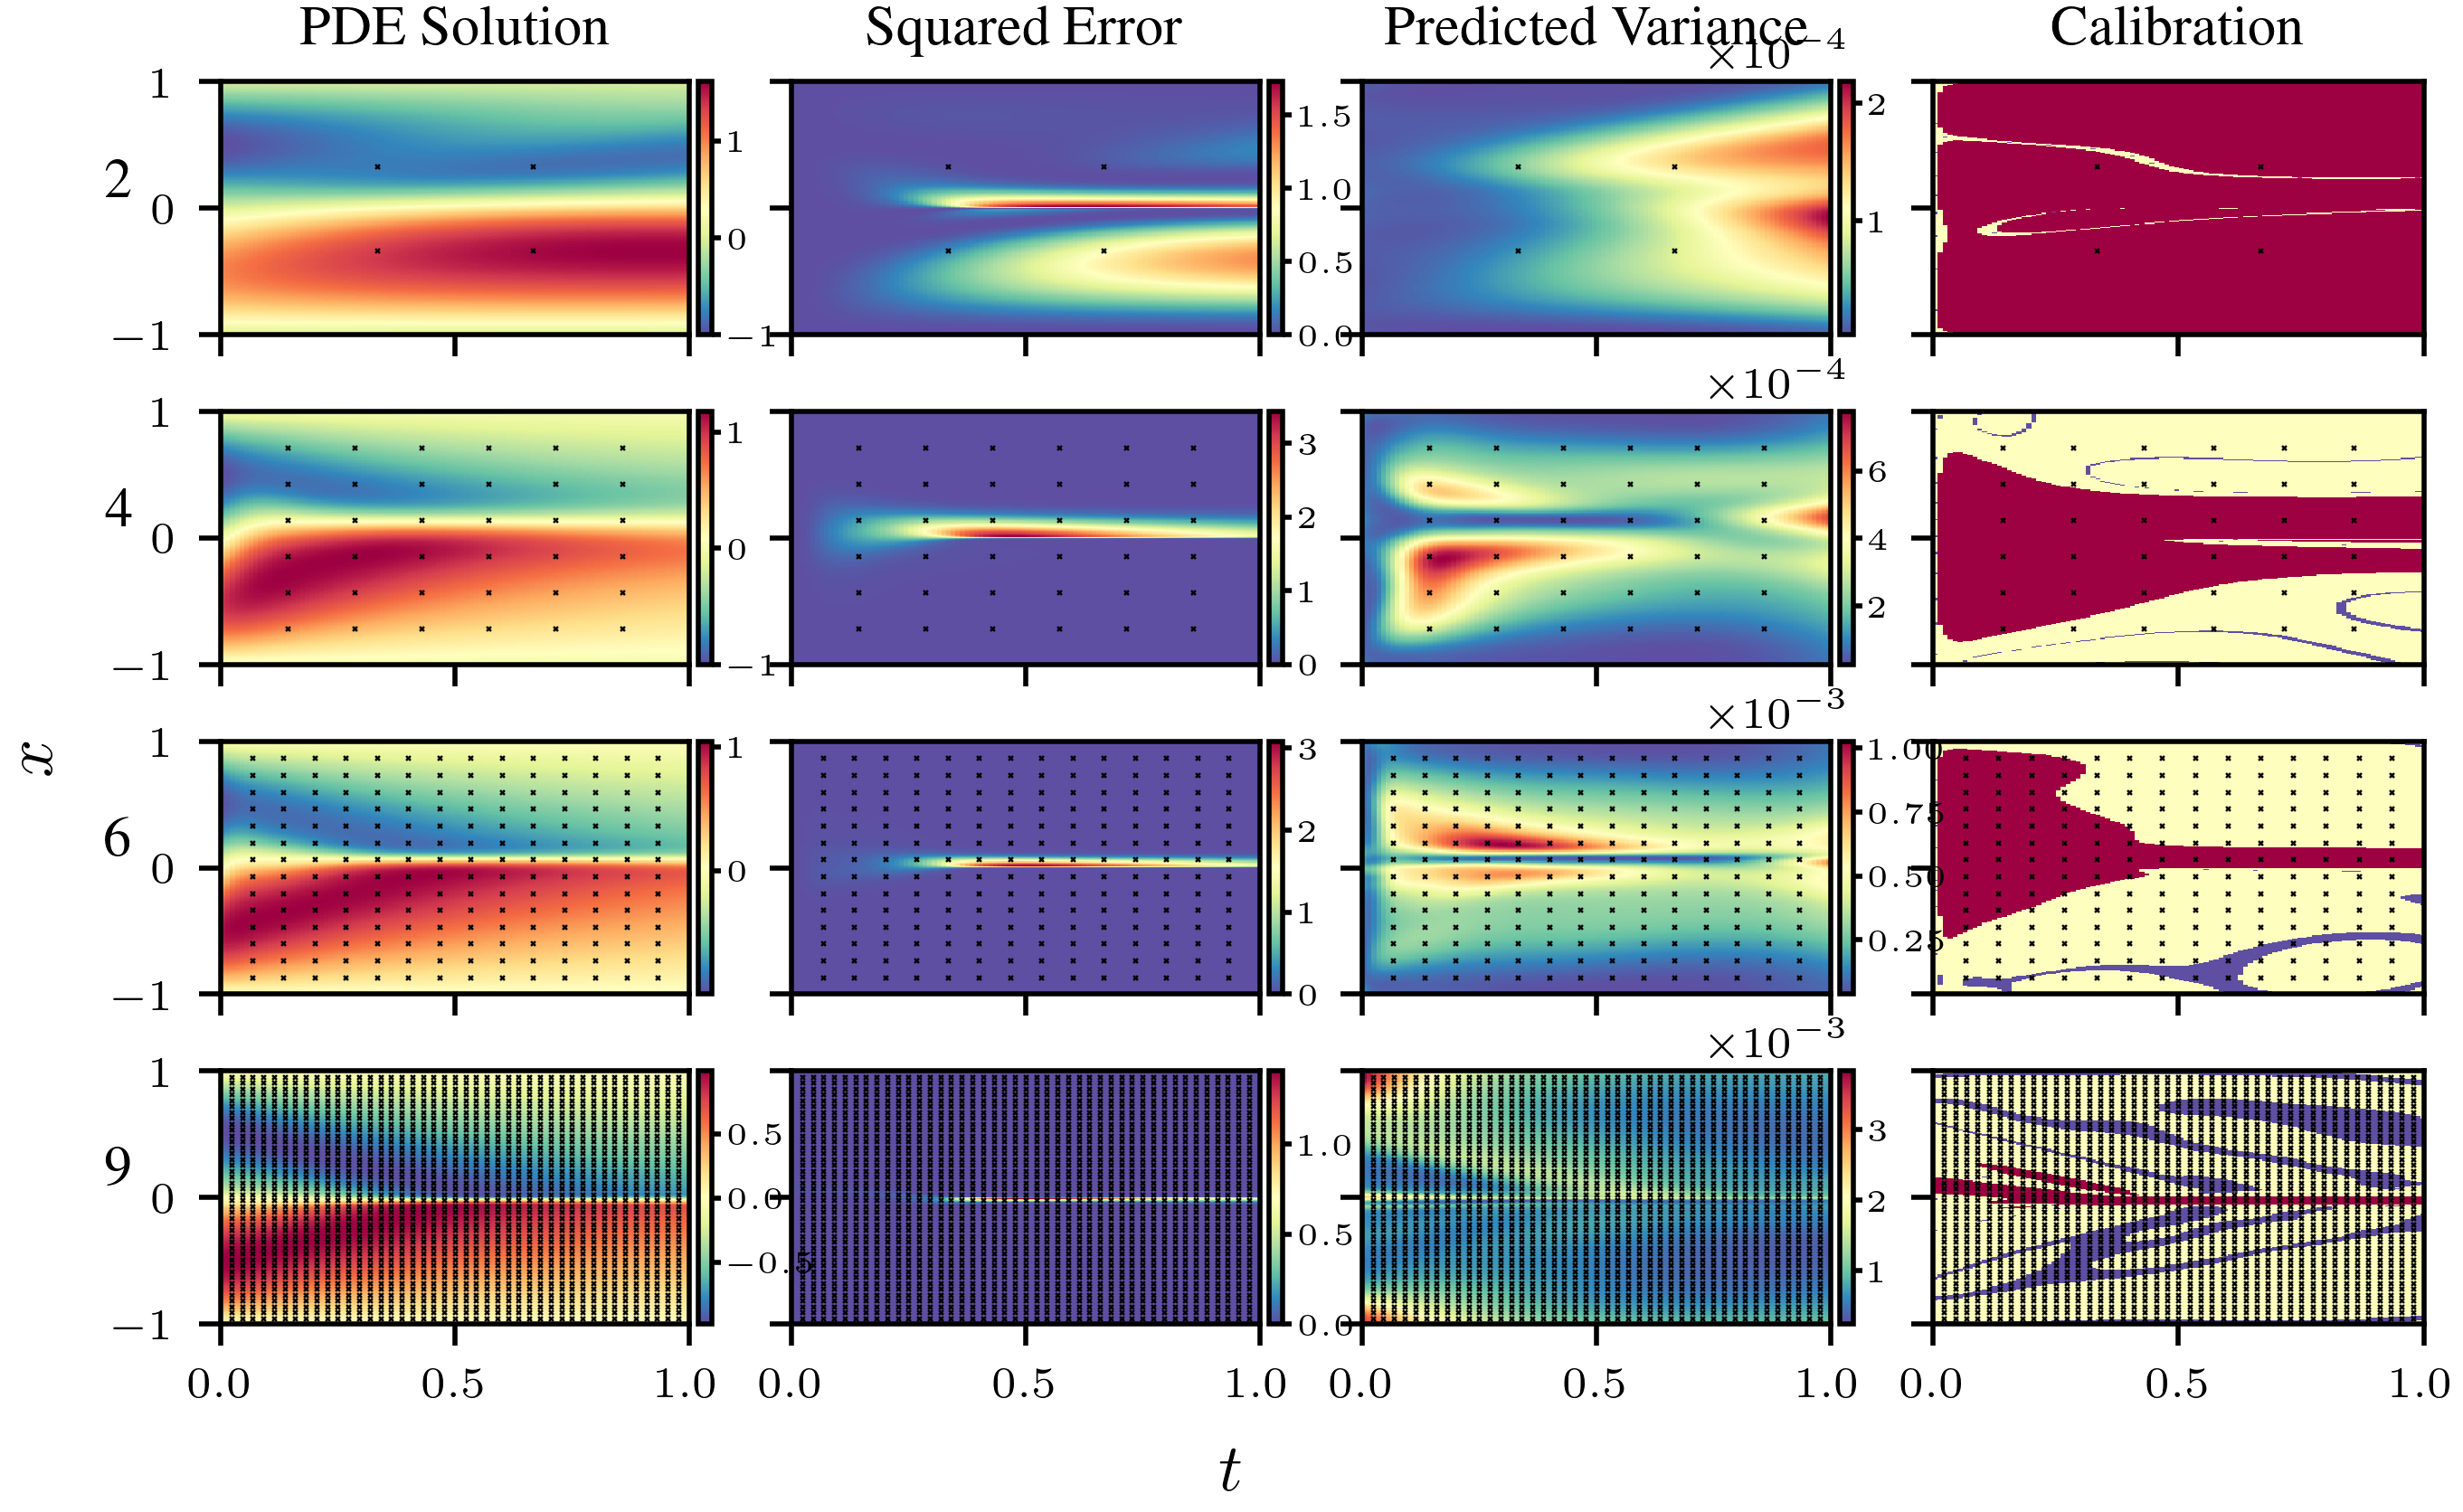

In [142]:
from tueplots import figsizes
#index=[0,1]
cmap='Spectral_r'
plt.rcParams['axes.unicode_minus'] = False
index=idx=[2,4,6,9]
arr=np.array([mean_cpu[idx,:],errs[idx,:]**2,np.sqrt(var_cpu[idx,:]**2),((errs**2)/var_cpu)[idx,:]])
arr=arr.transpose((1,0,-1))
#arr=arr.reshape(arr.shape[0]*arr.shape[1],-1)
arr=np.vstack(arr)
#idx=5
#arr=[errs[idx,:]**2,np.sqrt(var_cpu[idx,:]**2)]
rows=4
cols=4
plt.rcParams.update(figsizes.iclr2024(nrows=rows, ncols=cols))#,height_to_width_ratio=.5))
fig, axes = plt.subplots(nrows=rows, ncols=cols, sharex=True, sharey=True)
alpha=.05
#fig.text(0.5, -0.0, 'common X', ha='center')
#fig.text(-0.0, 0.5, 'common Y', va='center', rotation='vertical')
index=range(rows*cols)
for ax,i in zip(axes.flatten(),index):
    if i%4==3:
        c1,c2=chi2.ppf([alpha/2,1-alpha/2],1)
        bounds = [c1,c2]
        divnorm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')
        U_Y = griddata(X_exact, arr[i,:], (X, T), method='nearest')
        #gs0 = gridspec.GridSpec(1, 2)
        #gs0.update(top=1-0.06, bottom=1-1.0/3.0+0.06, left=0.15, right=0.85, wspace=0)
        h = ax.imshow(U_Y.T, interpolation='nearest',norm=divnorm, cmap=cmap, extent=[t.min(), t.max(), x.min(), x.max()], origin='lower', aspect='auto')
    else:
        U_Y = griddata(X_exact, arr[i], (X, T), method='nearest')
        #gs0 = gridspec.GridSpec(1, 2)
        #gs0.update(top=1-0.06, bottom=1-1.0/3.0+0.06, left=0.15, right=0.85, wspace=0)
        h = ax.imshow((U_Y).T, interpolation='nearest', cmap=cmap, extent=[t.min(), t.max(), x.min(), x.max()], origin='lower', aspect='auto')

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='3%', pad=0.02)
        fig.colorbar(h, cax=cax, orientation='vertical')

        cax.tick_params(length=1.5,labelsize=5,pad=1)
        #cax.tick_params(length=1,pad=1)

    #ax.set_xlabel('$t$')
    #ax.set_ylabel('$x$')
    grid_i=idx[int(i/4)]
    plot_points=grids[grid_i]
    x_col=plot_points[:,0]
    t_col=plot_points[:,1]
    ax.plot(t_col,x_col, 'kx', markersize = .25, clip_on = False)
axes[0,0].set_title('PDE Solution')
axes[0,1].set_title('Squared Error')
axes[0,2].set_title('Predicted Variance')
axes[0,3].set_title('Calibration')
axes[0,0].set_ylabel(idx[0],rotation=0,labelpad=-1)
axes[1,0].set_ylabel(idx[1],rotation=0,labelpad=-1)
axes[2,0].set_ylabel(idx[2],rotation=0,labelpad=-1)
axes[3,0].set_ylabel(idx[3],rotation=0,labelpad=-1)


#fig.subplots_adjust(bottom=0.2)
#fig.subplots_adjust()
fig.supxlabel('$t$')
fig.supylabel('$x$')
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#cax = divider.append_axes("right", size="5%", pad=0.05)
#fig.colorbar(h, cax=cbar_ax)
#fig.colorbar(h, ax=axes.ravel().tolist())
plt.show()